In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data, datasets
from torchsummaryX import summary

import pandas as pd
import numpy as np
import warnings

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

warnings.filterwarnings(action='ignore')

In [2]:
batch_size = 128
lr = 0.001
epochs = 40
train_history = []
val_history = []
val_acc_history = []

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
text = data.Field(sequential = True, batch_first = True, lower = True)
label = data.Field(sequential = False, batch_first = True)

# batch_first : 배치 크기를 첫번째 차원으로 해서 (배치 크기, 문장의 길이) 차원이 된다.

In [3]:
vars(text)

{'sequential': True,
 'use_vocab': True,
 'init_token': None,
 'eos_token': None,
 'unk_token': '<unk>',
 'fix_length': None,
 'dtype': torch.int64,
 'preprocessing': None,
 'postprocessing': None,
 'lower': True,
 'tokenizer_args': (None, 'en'),
 'tokenize': <function torchtext.data.utils._split_tokenizer(x)>,
 'include_lengths': False,
 'batch_first': True,
 'pad_token': '<pad>',
 'pad_first': False,
 'truncate_first': False,
 'stop_words': None,
 'is_target': False}

In [4]:
trainset, testset = datasets.IMDB.splits(text, label)

In [5]:
vars(trainset.examples[0]).keys()

dict_keys(['text', 'label'])

In [6]:
print(trainset.examples[0].text[0:10])
print(trainset.examples[0].label)
print(trainset.examples[1].label)

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy.', 'it', 'ran', 'at', 'the']
pos
pos


In [7]:
text.build_vocab(trainset, min_freq = 5)
label.build_vocab(trainset)

In [8]:
trainset, valset = trainset.split(split_ratio=0.8)
train_iter, val_iter, test_iter = data.BucketIterator.splits((trainset, valset, testset), batch_size=batch_size, shuffle=True, repeat=False)

In [9]:
next(iter(train_iter)).text.shape

torch.Size([128, 973])

In [10]:
vocab_size = len(text.vocab)
n_classes = 2
print("[Train]: %d [Val]: %d [Test]: %d [Vocab] %d [Classes] %d" %
     (len(trainset), len(valset), len(testset), vocab_size, n_classes))

[Train]: 20000 [Val]: 5000 [Test]: 25000 [Vocab] 46159 [Classes] 2


In [11]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        self.n_layers = n_layers
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim, num_layers=self.n_layers, batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)
        
    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.gru(x, h_0)
        h_t = x[:,-1,:]
        self.dropout(h_t)
        logit = self.out(h_t)
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [12]:
def train(model, optimizer, train_iter):
    model.train()
    train_loss = 0
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(device), batch.label.to(device)
        y.data.sub_(1)
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    train_loss /= (len(train_iter))
    train_history.append(train_loss) # 기록 저장
    print('Train [{}] \t Loss: {: .6f}'.format(epoch, train_loss))

In [13]:
def evaluate(model, val_iter):
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(device), batch.label.to(device)
        y.data.sub_(1)
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    
    val_history.append(avg_loss) # 기록 저장
    val_acc_history.append(avg_accuracy.item())

    return avg_loss, avg_accuracy

In [14]:
inputs = torch.zeros((128, 1001), dtype=torch.long) # [length, batch_size]
summary(BasicGRU(1, 128, vocab_size, 128, n_classes, 0.25).to("cpu"), inputs)

Building Basic GRU model...
           Kernel Shape      Output Shape     Params  Mult-Adds
Layer                                                          
0_embed    [128, 46159]  [128, 1001, 128]  5.908352M  5.908352M
1_gru                 -  [128, 1001, 128]    99.072k    98.304k
2_dropout             -        [128, 128]          -          -
3_out          [128, 2]          [128, 2]      258.0      256.0
---------------------------------------------------------------
                         Totals
Total params          6.007682M
Trainable params      6.007682M
Non-trainable params        0.0
Mult-Adds             6.006912M


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embed,"[128, 46159]","[128, 1001, 128]",5908352.0,5908352.0
1_gru,-,"[128, 1001, 128]",99072.0,98304.0
2_dropout,-,"[128, 128]",NaN,NaN
3_out,"[128, 2]","[128, 2]",258.0,256.0


In [15]:
model = BasicGRU(1, 256, vocab_size, 128, n_classes, 0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building Basic GRU model...


In [16]:
best_val_loss = None
for epoch in tqdm(range(1, epochs+1)):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)
    
    if epoch % 5 == 0:
        print('Val [{}] \t Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, val_loss, val_accuracy))
    
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassfication.pt')
        best_val_loss = val_loss

  0%|          | 0/40 [00:00<?, ?it/s]

Train [1] 	 Loss:  0.700016
Train [2] 	 Loss:  0.694708
Train [3] 	 Loss:  0.694392
Train [4] 	 Loss:  0.693777
Train [5] 	 Loss:  0.693628
Val [5] 	 Loss: 0.6910, Accuracy: 51.82%
Train [6] 	 Loss:  0.691348
Train [7] 	 Loss:  0.600836
Train [8] 	 Loss:  0.327575
Train [9] 	 Loss:  0.174977
Train [10] 	 Loss:  0.084177
Val [10] 	 Loss: 0.3375, Accuracy: 86.82%
Train [11] 	 Loss:  0.042306
Train [12] 	 Loss:  0.025530
Train [13] 	 Loss:  0.020764
Train [14] 	 Loss:  0.025710
Train [15] 	 Loss:  0.018613
Val [15] 	 Loss: 0.4479, Accuracy: 86.00%
Train [16] 	 Loss:  0.009400
Train [17] 	 Loss:  0.006675
Train [18] 	 Loss:  0.008099
Train [19] 	 Loss:  0.008605
Train [20] 	 Loss:  0.009224
Val [20] 	 Loss: 0.4901, Accuracy: 86.44%
Train [21] 	 Loss:  0.003549
Train [22] 	 Loss:  0.004822
Train [23] 	 Loss:  0.003897
Train [24] 	 Loss:  0.006122
Train [25] 	 Loss:  0.006971
Val [25] 	 Loss: 0.5306, Accuracy: 86.14%
Train [26] 	 Loss:  0.005240
Train [27] 	 Loss:  0.004338
Train [28] 	 Loss

In [17]:
model.load_state_dict(torch.load('./snapshot/txtclassfication.pt'))
val_loss, val_acc = evaluate(model, test_iter)
print('Test loss: %5.2f | Test accuracy: %5.2f' % (val_loss, val_acc))

Test loss:  0.33 | Test accuracy: 86.60


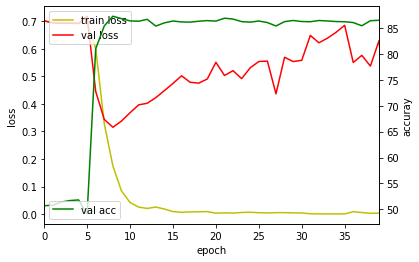

In [19]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_history, 'y', label='train loss')
loss_ax.plot(val_history, 'r', label='val loss')

acc_ax.plot(val_acc_history, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

loss_ax.set_xlim([0,39])
plt.show()